In [1]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-04-19 22:51:58.304843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-19 22:51:58.304868: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100000
num_val=20000
noise_level=0.
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=2, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [3]:
layers = (
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Nadam(lr=5e-5),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=11,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/11


/home/nikos/.venv/py3-tf2/lib/python3.8/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
2022-04-19 22:52:00.437800: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-19 22:52:00.437823: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-19 22:52:00.437857: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-04-19 22:52:00.438035: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To e

196/196 [==============================] - 1s 3ms/step - loss: 0.6791 - accuracy: 0.5256 - auc: 0.5854 - val_loss: 0.6633 - val_accuracy: 0.5465 - val_auc: 0.6444
Epoch 2/11
196/196 [==============================] - 0s 2ms/step - loss: 0.6498 - accuracy: 0.5728 - auc: 0.6860 - val_loss: 0.6380 - val_accuracy: 0.5901 - val_auc: 0.7196
Epoch 3/11
196/196 [==============================] - 0s 2ms/step - loss: 0.6274 - accuracy: 0.6096 - auc: 0.7406 - val_loss: 0.6185 - val_accuracy: 0.6247 - val_auc: 0.7587
Epoch 4/11
196/196 [==============================] - 0s 2ms/step - loss: 0.6065 - accuracy: 0.6438 - auc: 0.7757 - val_loss: 0.5990 - val_accuracy: 0.6567 - val_auc: 0.7841
Epoch 5/11
196/196 [==============================] - 0s 2ms/step - loss: 0.5881 - accuracy: 0.6704 - auc: 0.7935 - val_loss: 0.5815 - val_accuracy: 0.6801 - val_auc: 0.7982
Epoch 6/11
196/196 [==============================] - 0s 2ms/step - loss: 0.5716 - accuracy: 0.6938 - auc: 0.8026 - val_loss: 0.5598 - val_ac

In [4]:
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:1000, :], n=100)
post_lo_std = mcd_classifier.posterior_stddev_logodds(x_val[:1000, :], n=100)
#print("Posterior logodds mean(sd): {}({})".format(post_lo_mean, post_lo_std))
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
p_l = 1/(1 + np.exp(-(post_lo_mean[:, 0] - 1.96 * post_lo_std[:, 0]/np.sqrt(99))))
p_h = 1/(1 + np.exp(-(post_lo_mean[:, 0] + 1.96 * post_lo_std[:, 0]/np.sqrt(99))))

/home/nikos/.venv/py3-tf2/lib/python3.8/site-packages/modunc-0.1-py3.8.egg/uncertainty_testbed/uncertainty_models/mc_dropout.py:67: RuntimeWarning: divide by zero encountered in true_divide
  preds_logodds = np.log(np.stack(preds)/(1 - np.stack(preds)))
/home/nikos/.venv/py3-tf2/lib/python3.8/site-packages/modunc-0.1-py3.8.egg/uncertainty_testbed/uncertainty_models/mc_dropout.py:79: RuntimeWarning: divide by zero encountered in true_divide
  preds_logodds = np.log(np.stack(preds) / (1 - np.stack(preds)))
/home/nikos/.venv/py3-tf2/lib/python3.8/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [5]:
scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

In [6]:
scores[:10]

array([2.4482253 , 3.6959808 , 2.6154523 , 0.3840152 , 0.38606232,
       1.7627509 , 0.07277225, 1.978102  , 0.80666643, 0.16189876],
      dtype=float32)

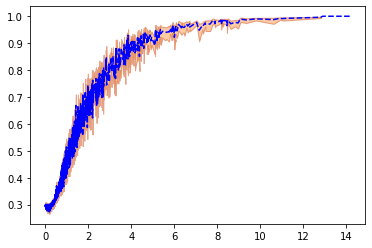

In [7]:
plt.plot(scores[ix_srt[::-1]], p[ix_srt[::-1]], '--b')
plt.fill_between(scores[ix_srt[::-1]], p_l[ix_srt[::-1]], p_h[ix_srt[::-1]], 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.show()

In [8]:
1/(1+np.exp(-post_lo_mean[ix_srt[0], 0]))

0.30193351580486516

In [9]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train=100000
num_val=20000
noise_level=0.3
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=2, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(num_train + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train:, :], y[num_train:]
#return x_train, y_train, x_val, y_val

In [10]:
layers = (
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(30, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Nadam(lr=5e-5),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=11,
    batch_size=512,
    validation_data=(x_val, y_val)
)

Epoch 1/11


/home/nikos/.venv/py3-tf2/lib/python3.8/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


196/196 [==============================] - 2s 3ms/step - loss: 0.6771 - accuracy: 0.5153 - auc: 0.6054 - val_loss: 0.6651 - val_accuracy: 0.5352 - val_auc: 0.6662
Epoch 2/11
196/196 [==============================] - 0s 3ms/step - loss: 0.6550 - accuracy: 0.5583 - auc: 0.6957 - val_loss: 0.6446 - val_accuracy: 0.5749 - val_auc: 0.7238
Epoch 3/11
196/196 [==============================] - 0s 3ms/step - loss: 0.6359 - accuracy: 0.5931 - auc: 0.7369 - val_loss: 0.6274 - val_accuracy: 0.6072 - val_auc: 0.7495
Epoch 4/11
196/196 [==============================] - 0s 2ms/step - loss: 0.6187 - accuracy: 0.6212 - auc: 0.7572 - val_loss: 0.6091 - val_accuracy: 0.6395 - val_auc: 0.7715
Epoch 5/11
196/196 [==============================] - 0s 2ms/step - loss: 0.6009 - accuracy: 0.6521 - auc: 0.7754 - val_loss: 0.5946 - val_accuracy: 0.6628 - val_auc: 0.7792
Epoch 6/11
196/196 [==============================] - 1s 3ms/step - loss: 0.5842 - accuracy: 0.6766 - auc: 0.7857 - val_loss: 0.5790 - val_ac

In [11]:
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:1000, :], n=100)
post_lo_std = mcd_classifier.posterior_stddev_logodds(x_val[:1000, :], n=100)
#print("Posterior logodds mean(sd): {}({})".format(post_lo_mean, post_lo_std))
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
p_l = 1/(1 + np.exp(-(post_lo_mean[:, 0] - 1.96 * post_lo_std[:, 0]/np.sqrt(99))))
p_h = 1/(1 + np.exp(-(post_lo_mean[:, 0] + 1.96 * post_lo_std[:, 0]/np.sqrt(99))))

In [12]:
scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

In [13]:
scores[:10]

array([2.4482253 , 3.6959808 , 2.6154523 , 0.3840152 , 0.38606232,
       1.7627509 , 0.07277225, 1.978102  , 0.80666643, 0.16189876],
      dtype=float32)

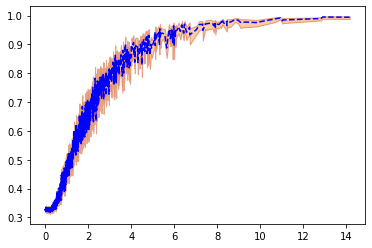

In [14]:
plt.plot(scores[ix_srt[::-1]], p[ix_srt[::-1]], '--b')
plt.fill_between(scores[ix_srt[::-1]], p_l[ix_srt[::-1]], p_h[ix_srt[::-1]], 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.show()

In [15]:
1/(1+np.exp(-post_lo_mean[ix_srt[0], 0]))

0.32869711212633596

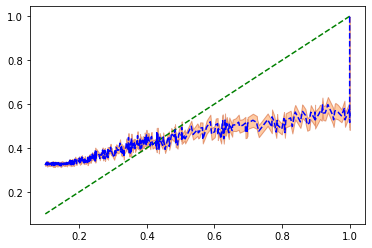

In [16]:
probs = eg.get_probabilities(x_val[:1000,:])[1]
plt.plot(probs[ix_srt[::-1]], probs[ix_srt[::-1]], '--g')
plt.plot(probs[ix_srt[::-1]], p[ix_srt[::-1]], '--b')
plt.fill_between(probs[ix_srt[::-1]], p_l[ix_srt[::-1]], p_h[ix_srt[::-1]], 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.show()

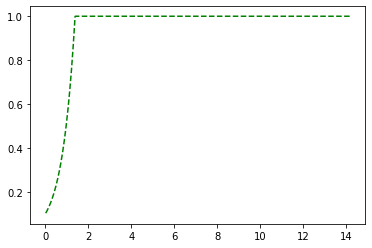

In [17]:
plt.plot(scores[ix_srt[::-1]], probs[ix_srt[::-1]], '--g')
plt.show()